# Bayesian linear regression
The code below shows how to reproduce the example in Figure 3.7 of Bishop's book, Pattern Recognition and Machine Learning. Although in the book the explanation of the steps needed to learn the model is excellent, as a beginner in this topic it was not clear to me how to obtain these results until I tried to implement the equations.

To get familiar with MCMC methods, in the last section the model parameters are sampled with the popular Metropolis-Hasting algorithm, as an alternative solution of generating directly from the posterior distribution.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
from scipy.stats import norm, multivariate_normal
from numpy.linalg import inv

Define a 1-D linear model with two parameters $\mathbf{w} = [w_0,\, w_1]$: 
\begin{equation}
y = y(x,\,\mathbf{w}) = w_0+w_1x = \mathbf{w}^T\mathbf{\phi(x)} 
\end{equation}
with basis function $\mathbf{\phi(x)}=[1,\, x]$.

The target variable $t$ is given by the deterministic function $y(x, \mathbf{w})$ with additive Gaussian noise, $\epsilon$:
\begin{equation}
y = y(x,\,\mathbf{w})+\epsilon
\end{equation}
where $\varepsilon$ is a zero mean Gausssian radnom variable with zero mean and precision $\beta=1/\sigma^2$, (inversion of variance):
\begin{equation}
\epsilon \sim \mathcal{N}(0,\,\beta^{-1})
\end{equation}

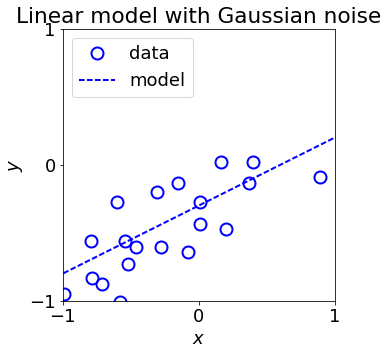

In [40]:
# Parameters
n = 20         # Number of points
a0 = -0.3      # Intercept
a1 = 0.5       # Slope
sigma = 0.2    # Gausssian noise standard deviation
# Model and target variables
x = np.random.uniform(-1,1,n)
y = a0+a1*x
e = np.random.normal(0,sigma,n)
t = y+e
# Plot the data
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(x, t, 'bo', linewidth=2, ms=12, mew=2, mfc='None', label = 'data')
x_plot = np.array([-1.1, 1.1])
ax.plot(x_plot, a0+a1*x_plot, 'b--', lw=2, label='model')
ax.set_aspect('equal')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Linear model with Gaussian noise')
ax.legend(loc=2)
plt.show()

The pdf of a single target variable is:
\begin{equation}
p(t\mid x,\mathbf{w},\beta) = \mathcal{N}(t \mid y(x,\mathbf{w}),\,\beta^{-1}) = \frac{1}{(2\pi \sigma^2)^{1/2}}\exp{\left(\frac{1}{2\sigma^2}(t-\mathbf{w}^T\mathbf{\phi}(x))\right)}
\end{equation}

where the parameter space is space $w_0 = [-1, +1]$ and $w_1 = [-1,+1]$.

Assuming that the target variables $[t_n]_{n=1}^{N}$ are drawn independently from the distrubution above, the likelihood function for the data set is:
\begin{equation}
p(\mathbf{t} \mid x,\mathbf{w},\beta) = \prod_{n=1}^N \mathcal{N}(t_n \mid \mathbf{w}^T\mathbf{\phi}(x_n),\,\beta^{-1})
\end{equation}

We define a coniugate Gaussian prior for the parmeter $\mathbf{w}$ with zero mean and covariance $\mathbf{S_0} = \alpha^{-1}\mathbf{I}$:
\begin{equation}
p(\mathbf{w} \mid \alpha) = \mathcal{N}(\mathbf{w} \mid \mathbf{m}_0, \mathbf{S}_0) = \mathcal{N}(\mathbf{w} \mid \mathbf{0},\alpha^{-1}\mathbf{I})
\end{equation}

In [41]:
# Parameter space
w0 = np.linspace(-1,1,100)
w1 = np.linspace(-1,1,100)
W0, W1 = np.meshgrid(w0,w1)
# Compute prior
alpha = 2
# Pack W0 and W1 into a single 3-dimensional array
pos = np.empty(W0.shape + (2,))
pos[:, :, 0] = W0
pos[:, :, 1] = W1
# Bivariate normal distribution, see:
# https://stackoverflow.com/questions/38698277/plot-normal-distribution-in-3d
# https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
mu_0 = np.array([0, 0])
S_0 = np.array([[1/alpha, 0],[0, 1/alpha]])
rv_prior =  multivariate_normal(mu_0, S_0)
# Prior pdf
prior = rv_prior.pdf(pos)
# Sample a set of 6 parameters from prior
w_s = rv_prior.rvs(size=6)

The figure below shows the prior, i.e. our initial ignorance about the model parameters $[w_0,\,w_1]$ before any data is observed, and 6 possible models sampled from the prior.

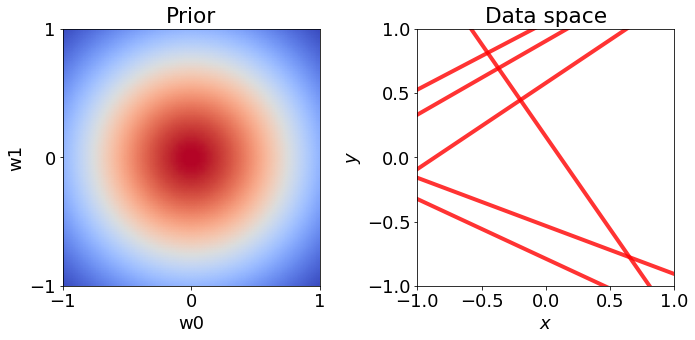

In [42]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.pcolormesh(W0, W1, prior, cmap='coolwarm', vmin=prior.min(), vmax=prior.max(), shading='gouraud')
ax1.set_aspect('equal')
ax1.set_xlabel('w0')
ax1.set_ylabel('w1')
ax1.set_xticks([-1, 0, 1])
ax1.set_yticks([-1, 0, 1])
ax1.set_title('Prior')
ax2 = fig.add_subplot(122)
for w in w_s:
    ax2.plot(x_plot, w[0]+w[1]*x_plot, 'r-', lw=4, alpha = 0.8)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Data space')
ax2.set_aspect('equal')
fig.tight_layout()
plt.show()

As the first data point $(x_0,\, t_0)$ is observed we can compute the likelihood for $this$ data point $p(t\mid x,\mathbf{w},\beta)$, and use it to calculate the posterior probability through Bayes' theorem:
\begin{equation}
p(\mathbf{w} \mid t,x,\beta,\alpha) \propto p(t\mid x,\mathbf{w},\beta)p(\mathbf{w} \mid \alpha)
\end{equation}

The posterior represents our updated "guess" of the model parameters given the data that we have observed. 

Since we want to sample parameters from the posterior pdf, is more efficient expressing the posterior with an analytical formula, rather then multiply the likelihood by the prior/posterior as in page 154 of Bishops'. The fact that prior pdf is a coniugate Gaussian leads to a Gaussian posterior with parameters described in Eqns. (3.49-3.51) of Bishop's book: 
\begin{equation}
p(\mathbf{w} \mid \mathbf{t}) = \mathcal{N}(\mathbf{w} \mid \mathbf{m}_N, \mathbf{S}_N)
\end{equation}

with

\begin{align}
\mathbf{m}_N &= \beta \mathbf{S}_N\mathbf{\Phi}^T \mathbf{t} \\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi}
\end{align}

where $\mathbf{\Phi}$ is the $n' \times 2$ matrix of basis functions $\phi(x) = [1,\, x]$. In this case $n'$ varies from 0 to the total number of data points $N$, based on the number of data that we have observed as will be shown below 

In [43]:
beta = (1/sigma)**2
def posterior(x, t, alpha, beta):
    n = len(x)
    Phi  = np.array([np.ones(n),x]).T
    Sn_inv = alpha*np.eye(2)+beta*np.dot(Phi.T, Phi)
    Sn = inv(Sn_inv)
    mn = beta*np.dot(Sn, np.dot(Phi.T, t[:,None]))
    mn = mn.flatten()
    rv_posterior =  multivariate_normal(mn, Sn)
    return rv_posterior

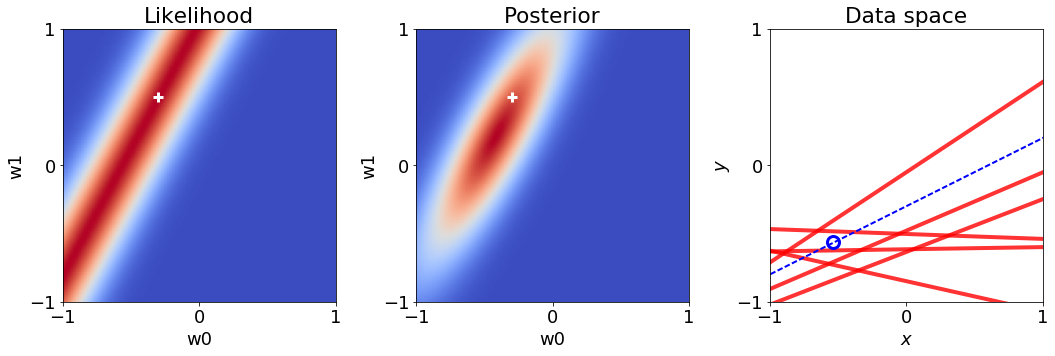

In [44]:
def model_learning(i):
    # Likelihood of data point
    Mu_0 = W0+W1*x[i-1]
    likelihood = norm(Mu_0, sigma).pdf(t[i-1])
    # Posterior after first observation
    rv_posterior = posterior(x[:i], t[:i], alpha, beta)
    # Sample 6 items from posterior
    w_s = rv_posterior.rvs(size=6)

    # Plot first step
    fig = plt.figure(figsize=(15,5))
    # Likelihood
    ax1 = fig.add_subplot(131)
    ax1.pcolormesh(W0, W1, likelihood, cmap='coolwarm', shading='gouraud')
    ax1.plot(a0, a1, '+w', ms=10, mew=3)
    ax1.set_aspect('equal')
    ax1.set_xlabel('w0')
    ax1.set_ylabel('w1')
    ax1.set_xticks([-1, 0, 1])
    ax1.set_yticks([-1, 0, 1])
    ax1.set_title('Likelihood')
    # Posterior
    ax2 = fig.add_subplot(132)
    ax2.pcolormesh(W0, W1, rv_posterior.pdf(pos), cmap='coolwarm', shading='gouraud')
    ax2.plot(a0, a1, '+w', ms=10, mew=3)
    ax2.set_aspect('equal')
    ax2.set_xlabel('w0')
    ax2.set_ylabel('w1')
    ax2.set_xticks([-1, 0, 1])
    ax2.set_yticks([-1, 0, 1])
    ax2.set_title('Posterior')
    # Model
    ax3 = fig.add_subplot(133)
    for w in w_s:
        ax3.plot(x_plot, w[0]+w[1]*x_plot, 'r-', lw=4, alpha = 0.8)
    ax3.plot(x[:i], t[:i], 'bo', linewidth=2, ms=12, mew=3, mfc='None')
    ax3.plot(x_plot, a0+a1*x_plot, 'b--', lw=2)
    ax3.set_xlim(-1,1)
    ax3.set_ylim(-1,1)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$y$')
    ax3.set_xticks([-1, 0, 1])
    ax3.set_yticks([-1, 0, 1])
    ax3.set_title('Data space')
    ax3.set_aspect('equal')
    fig.tight_layout()
    plt.show()

# Results after fisrt data point is observed
model_learning(1)

After the second data point is observed the likelihood and the posterior can be recalculated to have a better estimate of the model

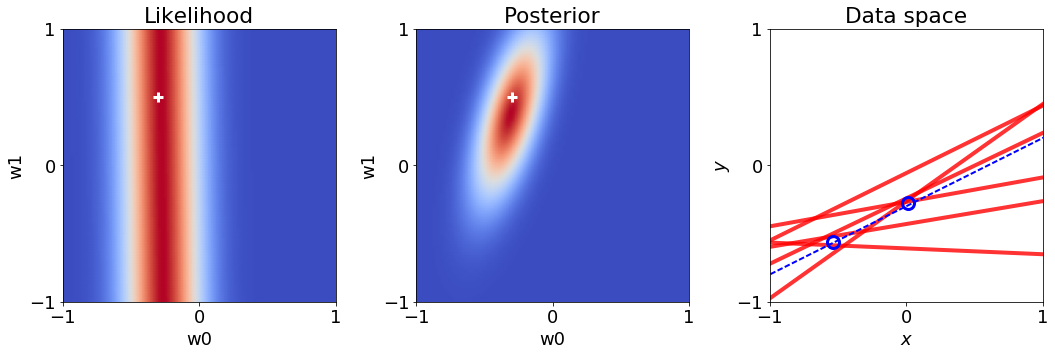

In [45]:
model_learning(2)

Once we have observed the 20th data point we obtain the results below

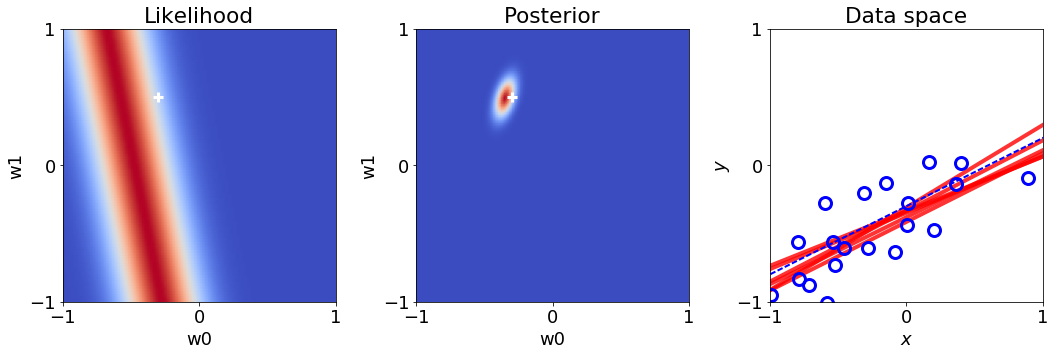

In [46]:
model_learning(20)

## MCMC sampling with Metropolis-Hasting algorithm
Rather than sampling parameters directly from the posterior pdf, another approach is to simulate instances which are consistent with the posterior through a Markov chain Monte Carlo method. Although this is usually done for more complicated pdf, the pourpose here is to learn and compare the two approaches.

Given a random variable $z \sim p(z)$, where $p(z)$ is the target pdf, at each iteration of the Metropolis algorithm a new sample $z*$ is obtained by exploring the space around $z(\tau)$ at current time $\tau$ through a symmetrical proposal distribution.

If the $p(z*)>p(z)$ the sample is accepted, otherwise it is accepted with probability $p(z*)/p(z)$. The initial burn-in period is eliminated, and samples are selected at regular instervals to obtain independency of the variables. 

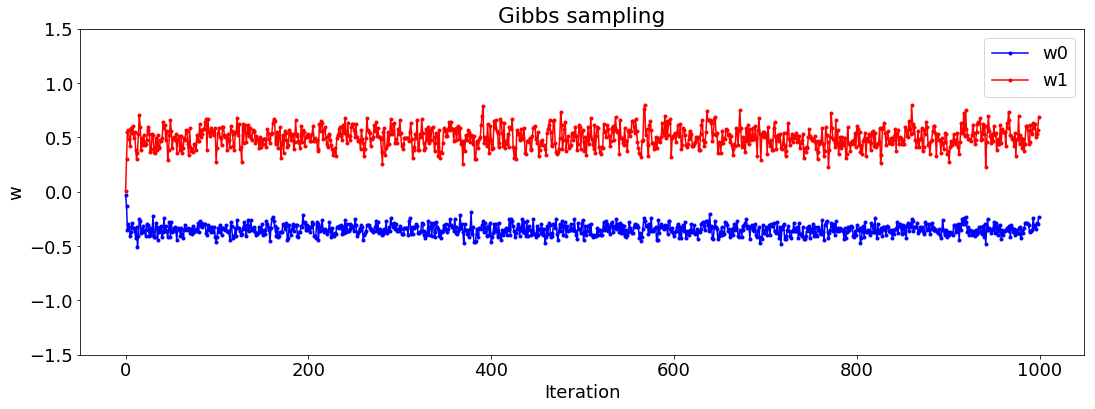

In [62]:
N = 10000        # Number of iterations
s = 10           # Sampling interval
r = np.zeros(2)  # Initial value
# Target pdf: posterior distribution
rv_posterior = posterior(x[:20], t[:20], alpha, beta)
p = rv_posterior.pdf(r)
samples = []
for i in range(N):
    # proposal distribution: zero mean Gaussian with std=0.1
    rn = r + np.random.normal(0, 0.1, size=2)
    pn = rv_posterior.pdf([rn[0], rn[1]])
    if pn >= p:  
        p = pn
        r = rn
    else:
        u = np.random.rand()
        if u < pn/p:
            p = pn
            r = rn
    if i % s == 0:
        samples.append(r)
 
samples = np.array(samples)

# Plot iterations
fig_1 = plt.figure(figsize=(18,6))
ax1 = fig_1.add_subplot(111)
ax1.plot(samples[:,0], 'b.-', label='w0')
ax1.plot(samples[:,1], 'r.-', label='w1')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('w')
ax1.legend()
ax1.set_ylim(-1.5,1.5)
ax1.set_title('Gibbs sampling')
plt.show()
# Eliminate initial burn-in period
w = samples[100:]

The samples are plotted in parameters space and compared with the target posterior pdf. Finally 6 samples are drawn and used to reproduce the model as done above

[631  74 419 716 306 234]


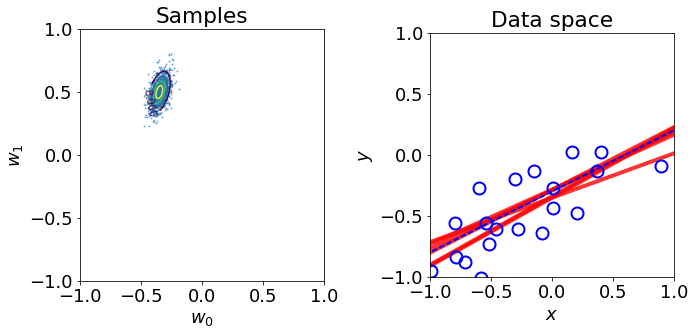

In [64]:
# Select from MCMC parameters
indexes = np.random.choice(len(w), size=6)
print(indexes)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.scatter(w[:,0], w[:,1], alpha=0.5, s=1)
CS = ax1.contour(W0, W1, rv_posterior.pdf(pos), 5)
ax1.clabel(CS, inline=1, fontsize=10)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_title('Samples')
ax1.set_xlabel('$w_0$')
ax1.set_ylabel('$w_1$')
ax2 = fig.add_subplot(122)
x_plot = np.array([-1.1, 1.1])
for index in indexes:
    ax2.plot(x_plot, w[index][0]+w[index][1]*x_plot, 'r-', lw=4, alpha = 0.8)
ax2.plot(x[:20], t[:20], 'bo', linewidth=2, ms=12, mew=2, mfc='None')
ax2.plot(x_plot, a0+a1*x_plot, 'b--', lw=2)
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Data space')
ax2.set_aspect('equal')
fig.tight_layout()
plt.show()